Please download the dataset from: http://visiondata.cis.upenn.edu/ordinal/lsp-mpii/lsp-mpii-ordinal.zip

Also make sure to change the paths while loading the data

# Setup: Imports

In [1]:
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from torchvision import transforms
import h5py
import cv2
import imageio

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
########## DO NOT Run Multiple time 
# !wget http://visiondata.cis.upenn.edu/ordinal/lsp-mpii/lsp-mpii-ordinal.zip -P /content/drive/Shareddrives/CIS680_project_data/

In [4]:
# !unzip -q /content/drive/Shareddrives/CIS680_project_data/lsp-mpii-ordinal.zip -d /content/drive/Shareddrives/CIS680_project_data/

In [5]:
#!pip -q install pypcd
# !python3.6 -m pip install --user git+https://github.com/DanielPollithy/pypcd.git

# DATASET

In [3]:
import scipy.io
import imageio
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path, param_dict, dataset):  # path[0]: Image path, #path[1]: joint_path, #path[2]: ordinal_path  
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.image_path  = path[0]
        self.joint_mat   = scipy.io.loadmat(path[1])
        self.ordinal_mat = scipy.io.loadmat(path[2])
        self.joint_data  = self.joint_mat["joints"]
        self.ord_data    = self.ordinal_mat["ord"]
        self.normalize   = transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        self.dataset     = dataset
        self.columns     = np.append(np.arange(6),np.arange(8,16))

    def __getitem__(self, index):
        '''
        Takes in index and returns: 
        img          , shape: ()
        joint_pos    , shape: (3,14)
        ord_relation , shape: (14,14)      
        '''
        if self.dataset == "LSP":
          img_idx = str(index + 1).zfill(4) # raw image data is 1-indexed
          img = imageio.imread(self.image_path + "im" + img_idx + ".jpg")        
        
        elif self.dataset == "MPII":
          img_idx = str(index + 1).zfill(5) # raw image data is 1-indexed
          img = imageio.imread(self.image_path + img_idx + "_full.jpg")

        joint_pos    = self.joint_data[:,:,index]
        ord_relation = self.ord_data[index]

        img, joint_pos = self.pre_process_batch(img, joint_pos)        
        
        img          = torch.tensor(img.astype(np.float),       dtype = torch.float).to(self.device)
        joint_pos    = torch.tensor(joint_pos.astype(np.float), dtype = torch.float).to(self.device)
        ord_relation = torch.tensor(ord_relation,               dtype = torch.float).to(self.device)
        if self.dataset == "MPII":
          ord_relation   = ord_relation[self.columns[:,np.newaxis],self.columns]
          joint_pos = joint_pos[:,self.columns]   

        return img, joint_pos, ord_relation

    def pre_process_batch(self, img, joint_data):
        max_x = np.max(joint_data[0,:])
        min_x = np.min(joint_data[0,:])

        max_y = np.max(joint_data[1,:])
        min_y = np.min(joint_data[1,:])

        w = max_x - min_x
        h = max_y - min_y
        eps = 100
        s = max(h,w) + eps
        scale = np.sqrt(s*s)

        centerx = (max_x + min_x)/2
        centery = (max_y + min_y)/2

        xA,xB,yA,yB = int(centerx - scale/2), int(centerx + scale/2), int(centery - scale/2), int(centery + scale/2)  
        cropped_img = np.zeros(((yB-yA),(xB-xA),3),dtype=img.dtype)
        # Range to fill new array

        new_x = max(0, -xA), min(xB, img.shape[1]) - xA
        new_y = max(0, -yA), min(yB, img.shape[0]) - yA

        # Range to sample from original image
        old_x = max(0, xA), min(img.shape[1], xB)
        old_y = max(0, yA), min(img.shape[0], yB)
        cropped_img[new_y[0]:new_y[1], new_x[0]:new_x[1],:] = img[old_y[0]:old_y[1], old_x[0]:old_x[1],:]
        new_joint_pos =  np.zeros(joint_data[:,:].shape)
        new_joint_pos[0,:] = joint_data[0,:] - old_x[0]
        new_joint_pos[1,:] = joint_data[1,:] - old_y[0]

        res = (256,256)
        resized_image     = cv2.resize(cropped_img, dsize=res, interpolation=cv2.INTER_LINEAR)
        resized_joint_pos =  np.zeros(new_joint_pos.shape)
        resized_joint_pos[0,:] = (new_joint_pos[0,:]*res[0]/cropped_img.shape[1])
        resized_joint_pos[1,:] = (new_joint_pos[1,:]*res[1]/cropped_img.shape[0])
 
        resized_image = np.transpose(resized_image, (2,0,1))

        x = np.random.randint(4)
  

        if x==0:
          output_image = resized_image
          output_joint_pos = resized_joint_pos
        elif x==1:
          output_image, output_joint_pos = self.flip_image(resized_image,resized_joint_pos)
        elif x==2:
          output_image, output_joint_pos = self.rotate_image(resized_image,resized_joint_pos, 30)
        elif x==3:
          output_image, output_joint_pos = self.rotate_image(resized_image,resized_joint_pos, -30)

        return output_image, output_joint_pos

    def flip_image(self, img, joint_pos):
      #print(img.shape)
      flipped_image = np.flip(img, axis=-1) 
      flipped_joint_pos =  np.zeros(joint_pos.shape)
      flipped_joint_pos[0,:] = 256- joint_pos[0,:]
      flipped_joint_pos[1,:] = joint_pos[1,:]
      flipped_joint_pos[2,:] = joint_pos[2,:]
      return flipped_image, flipped_joint_pos

    def rotate_image(self, image, joint_pos, theta):
      delta_theta = theta*np.pi/180

      T = np.eye(3)
      T[0,2] = -256/2
      T[1,2] = -256/2

      R = np.eye(3)
      R[0,0] = R[1,1] = np.cos(delta_theta)
      R[0,1] = -np.sin(delta_theta)
      R[1,0] = np.sin(delta_theta)

      transform = np.matmul(np.linalg.inv(T),np.matmul(R,T))
      M = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[2]/2), -theta, 1);
      rotated_image = cv2.warpAffine(image.transpose((1,2,0)), M, (image.shape[1], image.shape[2]))
      
      initial_points = np.ones(joint_pos.shape)
      initial_points[0,:] = joint_pos[0,:]
      initial_points[1,:] = joint_pos[1,:]
      rotated_points = np.matmul(transform,initial_points)
      rotated_points[2,:] = joint_pos[1,:]
      return rotated_image.transpose((2,0,1)), rotated_points
    
    def __len__(self):
        return self.joint_data.shape[2]




class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers


    def collect_fn(self, batch):
        
        out_batch = {}
        # bz = len(batch)
        
        img_list         = []
        jointPos_list    = []
        ordRelation_list = []       

        for img, joint_pos, ord_relation in batch:
          img_list.append(img)
          jointPos_list.append(joint_pos)
          ordRelation_list.append(ord_relation)

        out_batch['images']       = torch.stack(img_list,dim=0)
        out_batch['joint_pos']    = torch.stack(jointPos_list, dim=0)
        out_batch['ord_relation'] = torch.stack(ordRelation_list, dim=0)
        return out_batch


    def loader(self):
        return DataLoader(self.dataset,
                          batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          collate_fn=self.collect_fn)

batch size: 2
batch size: 2


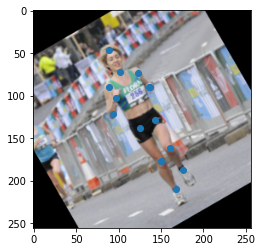

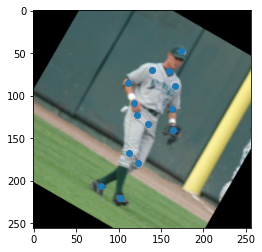

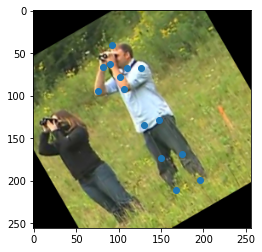

In [4]:
############ BUILDING THE LSP DATASET AND DATA LOADER#############
imgs_path_lsp          = "/content/drive/Shareddrives/CIS680_project_data/lsp-mpii-ordinal/lsp_dataset_original/images/"
joint_data_path_lsp    = "/content/drive/Shareddrives/CIS680_project_data/lsp-mpii-ordinal/lsp_dataset_original/joints.mat"
ordinal_data_path_lsp  = "/content/drive/Shareddrives/CIS680_project_data/lsp-mpii-ordinal/lsp_dataset_original/ordinal.mat"

param_dict={} 

LSPpaths = [imgs_path_lsp, joint_data_path_lsp, ordinal_data_path_lsp]
LSPdataset = BuildDataset(LSPpaths, param_dict, "LSP")

full_size = len(LSPdataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

torch.random.manual_seed(1)
LSPtrain_dataset, LSPtest_dataset = torch.utils.data.random_split(LSPdataset, [train_size, test_size])

batch_size = 2
print("batch size:", batch_size)
LSPtrain_build_loader = BuildDataLoader(LSPtrain_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
LSPtrain_loader = LSPtrain_build_loader.loader()


############ BUILDING THE MPII DATASET AND DATA LOADER#############
imgs_path_mpii          = "/content/drive/Shareddrives/CIS680_project_data/lsp-mpii-ordinal/mpii_upis1h/images/"
joint_data_path_mpii    = "/content/drive/Shareddrives/CIS680_project_data/lsp-mpii-ordinal/mpii_upis1h/joints.mat"
ordinal_data_path_mpii  = "/content/drive/Shareddrives/CIS680_project_data/lsp-mpii-ordinal/mpii_upis1h/ordinal.mat"

param_dict={} 

MPIIpaths = [imgs_path_mpii, joint_data_path_mpii, ordinal_data_path_mpii]
MPIIdataset = BuildDataset(MPIIpaths, param_dict, "MPII")

full_size = len(MPIIdataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

torch.random.manual_seed(1)
MPIItrain_dataset, MPIItest_dataset = torch.utils.data.random_split(MPIIdataset, [train_size, test_size])

batch_size = 2
print("batch size:", batch_size)
MPIItrain_build_loader = BuildDataLoader(MPIItrain_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
MPIItrain_loader = MPIItrain_build_loader.loader()
MPIItest_loader = BuildDataLoader(MPIItest_dataset, batch_size=batch_size, shuffle=False, num_workers=0).loader()

########TESTS############
run_tests = True
if run_tests:
    img, joint_pos, ord_relation = LSPdataset[0]
    #print(img.shape)
    #print(joint_pos.shape)
    #print(ord_relation.shape)
    plt.figure()
    plt.imshow(np.uint8(img.cpu().numpy().transpose(1,2,0)))
    plt.scatter(joint_pos[0,:].cpu().numpy(), joint_pos[1,:].cpu().numpy())
    plt.show()

    for i, data in enumerate(LSPtrain_loader):
        img          = data["images"]
        joint_pos    = data["joint_pos"]
        ord_relation = data["ord_relation"]
        #print(img.shape)
        #print(joint_pos.shape)
        #print(ord_relation.shape)
        plt.figure()
        plt.imshow(np.uint8(img[0].cpu().numpy().transpose(1,2,0)))
        plt.scatter(joint_pos[0,0,:].cpu().numpy(), joint_pos[0,1,:].cpu().numpy())
        plt.show()

        break


    for i,data in enumerate(MPIItrain_loader):
        img          = data["images"]
        joint_pos    = data["joint_pos"]
        ord_relation = data["ord_relation"] 
        plt.figure()
        plt.imshow(np.uint8(img[0].cpu().numpy().transpose(1,2,0)))
        plt.scatter(joint_pos[0,0,:].cpu().numpy(), joint_pos[0,1,:].cpu().numpy())
        plt.show()
        #print(img.shape)
        #print(joint_pos.shape)
        #print(ord_relation.shape)
        break

##############################

# Models

## Stacked Hourglass
[Original Paper](https://arxiv.org/abs/1603.06937)

[Reference Implementation](https://github.com/bearpaw/pytorch-pose/blob/master/pose/models/hourglass.py)

In [5]:
# Define HourglassNet and submodels

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 2, kernel_size=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class Hourglass(nn.Module):
    def __init__(self, block, num_blocks, planes, depth):
        super(Hourglass, self).__init__()
        self.depth = depth
        self.block = block
        self.hg = self._make_hour_glass(block, num_blocks, planes, depth)

    def _make_residual(self, block, num_blocks, planes):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(planes*block.expansion, planes))
        return nn.Sequential(*layers)

    def _make_hour_glass(self, block, num_blocks, planes, depth):
        hg = []
        for i in range(depth):
            res = []
            for j in range(3):
                res.append(self._make_residual(block, num_blocks, planes))
            if i == 0:
                res.append(self._make_residual(block, num_blocks, planes))
            hg.append(nn.ModuleList(res))
        return nn.ModuleList(hg)

    def _hour_glass_forward(self, n, x):
        up1 = self.hg[n-1][0](x)
        low1 = F.max_pool2d(x, 2, stride=2)
        low1 = self.hg[n-1][1](low1)

        if n > 1:
            low2 = self._hour_glass_forward(n-1, low1)
        else:
            low2 = self.hg[n-1][3](low1)
        low3 = self.hg[n-1][2](low2)
        up2 = F.interpolate(low3, scale_factor=2)
        out = up1 + up2
        return out

    def forward(self, x):
        return self._hour_glass_forward(self.depth, x)


class HourglassNet(nn.Module):
    '''Hourglass model from Newell et al ECCV 2016'''
    def __init__(self, block, num_stacks=2, num_blocks=4, num_classes=16):
        super(HourglassNet, self).__init__()

        self.inplanes = 64
        self.num_feats = 128
        self.num_stacks = num_stacks
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=True)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_residual(block, self.inplanes, 1)
        self.layer2 = self._make_residual(block, self.inplanes, 1)
        self.layer3 = self._make_residual(block, self.num_feats, 1)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.linear = nn.Linear(4096,3)

        # build hourglass modules
        ch = self.num_feats*block.expansion
        hg, res, fc, score, fc_, score_ = [], [], [], [], [], []
        for i in range(num_stacks):
            hg.append(Hourglass(block, num_blocks, self.num_feats, 4))
            res.append(self._make_residual(block, self.num_feats, num_blocks))
            fc.append(self._make_fc(ch, ch))
            score.append(nn.Conv2d(ch, num_classes, kernel_size=1, bias=True))
            if i < num_stacks-1:
                fc_.append(nn.Conv2d(ch, ch, kernel_size=1, bias=True))
                score_.append(nn.Conv2d(num_classes, ch, kernel_size=1, bias=True))
        self.hg = nn.ModuleList(hg)
        self.res = nn.ModuleList(res)
        self.fc = nn.ModuleList(fc)
        self.score = nn.ModuleList(score)
        self.fc_ = nn.ModuleList(fc_)
        self.score_ = nn.ModuleList(score_)

    def _make_residual(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=True),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_fc(self, inplanes, outplanes):
        bn = nn.BatchNorm2d(inplanes)
        conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=True)
        return nn.Sequential(
                conv,
                bn,
                self.relu,
            )

    def forward(self, x):
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.maxpool(x)
        x = self.layer2(x)
        x = self.layer3(x)

        for i in range(self.num_stacks):
            y = self.hg[i](x)
            y = self.res[i](y)
            pre_fc = y.clone()
            y = self.fc[i](y)
            score = self.score[i](y)
            
            score_flatten = score.view(score.shape[0],score.shape[1],-1)
            depth_score = self.linear(score_flatten)

            out.append((score, depth_score, pre_fc))
            if i < self.num_stacks-1:
                fc_ = self.fc_[i](y)
                score_ = self.score_[i](score)
                x = x + fc_ + score_

        return out

class DepthPredNet(nn.Module):

    def __init__(self, num_layers=5, num_joints=14, heatmap_size=64):
        super(DepthPredNet, self).__init__()

        in_size = num_joints * heatmap_size * heatmap_size
        out_size = num_joints # Z value for each joint

        self.layers = nn.Sequential(
            nn.Linear(in_size, in_size // 8),
            nn.LeakyReLU(),
            nn.Linear(in_size // 8, in_size // 32),
            nn.LeakyReLU(),
            nn.Linear(in_size // 32, in_size // 64),
            nn.LeakyReLU(),
            nn.Linear(in_size // 64, in_size // 256),
            nn.LeakyReLU(),
            nn.Linear(in_size // 256, out_size),
            nn.ReLU(),
        )
    
    def forward(self, X):
        X = X.view(X.shape[0], -1)
        # bz, joint, heatmap_y, heatmap_x
        return self.layers(X)
        
class DepthPredNet2(nn.Module):

    def __init__(self):
        super(DepthPredNet2, self).__init__()

        self.pool = nn.MaxPool2d(4, 4)

        in_size = 14 * 16 * 16
        out_size = 14 # Z value for each joint

        self.fc_layers = nn.Sequential(
            nn.Linear(in_size, in_size // 4),
            nn.LeakyReLU(),
            nn.Linear(in_size // 4, in_size // 16),
            nn.LeakyReLU(),
            nn.Linear(in_size // 16, out_size),
            nn.Tanh(),
        )
    
    def forward(self, X):
        # X: {bz, joint, heatmap_y, heatmap_x}
        X = self.pool(X) # {bz, joint, heatmap_y/4}
        X = X.view(X.shape[0], -1) # {2, 14 * 16 * 16}
        X = self.fc_layers(X)

        return X

class DepthPredNet3(nn.Module):
    """
    Predicts relative depth from second-to-last layer of hourglass network
        (before fully-connected layers that produce heatmaps)
    """
    def __init__(self):
        super(DepthPredNet3, self).__init__()

        # 1x1 conv used for channel size reduction
        self.conv_layers = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=1, padding=0),
            nn.BatchNorm2d(64),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 64 * 64, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 14),
            nn.Tanh()
        )
    
    def forward(self, X):
        # X: {bz, 256, 64, 64}
        X = self.conv_layers(X)
        X = X.view(X.shape[0], -1)
        # X: {bz, 64 * 64 * 64}
        X = self.fc_layers(X)
        return X

# Helper function for ground truth joint heatmap
def img_gaussian(img, pt, sigma=1):
    # Draw a 2D gaussian

    # Check that any part of the gaussian is in-bounds
    ul = [int(pt[0] - 3 * sigma), int(pt[1] - 3 * sigma)]
    br = [int(pt[0] + 3 * sigma + 1), int(pt[1] + 3 * sigma + 1)]
    if (ul[0] > img.shape[1] or ul[1] >= img.shape[0] or
            br[0] < 0 or br[1] < 0):
        # If not, just return the image as is
        return img

    # Generate gaussian
    size = 6 * sigma + 1
    # x = np.arange(0, size, 1, float)
    # y = x[:, np.newaxis]
    x = torch.arange(size, dtype=torch.float)
    y = x.unsqueeze(1)
    
    x0 = y0 = size // 2
    # The gaussian is not normalized, we want the center value to equal 1
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    # Usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], img.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], img.shape[0]) - ul[1]
    # Image range
    img_x = max(0, ul[0]), min(br[0], img.shape[1])
    img_y = max(0, ul[1]), min(br[1], img.shape[0])

    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    return img

# Loss Functions

In [10]:
# Joint Heatmap Loss
class JointsMSELoss(nn.Module):
    def __init__(self, use_target_weight=False):
        super(JointsMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='mean')
        self.use_target_weight = use_target_weight

    def forward(self, output, target, target_weight=None):
        batch_size = output.size(0)
        num_joints = output.size(1)
        heatmaps_pred = output.reshape((batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)
        loss = 0

        for idx in range(num_joints):
            heatmap_pred = heatmaps_pred[idx].squeeze()
            heatmap_gt = heatmaps_gt[idx].squeeze()
            if self.use_target_weight:
                loss += 0.5 * self.criterion(
                    heatmap_pred.mul(target_weight[:, idx]),
                    heatmap_gt.mul(target_weight[:, idx])
                )
            else:
                loss += 0.5 * self.criterion(heatmap_pred, heatmap_gt)

        return loss / num_joints

class JointKeypointMSELoss(nn.Module):
    def __init__(self):
        super(JointKeypointMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, output, target):
        batch_size = output.size(0)
        num_joints = output.size(1)
        
        # change to {bz, joint, xyz}, drop z, and flatten
        target = target.permute(0, 2, 1)[:, :, :2].contiguous().view(-1, 2)
        
        # get max inds and convert to 2D coords
        pred_max = output.view(batch_size, num_joints, -1).argmax(2).view(-1)
        pred_xy = torch.vstack((pred_max % 64, pred_max // 64)).T

        # euclidean distance in coordinate space
        dist = ((target[:, 0] - pred_xy[:, 0]).pow(2) + (target[:, 1] - pred_xy[:, 1]).pow(2)).pow(.5)
        
        return dist.sum() / len(dist)

# Ordinal Depth Loss 
class OrdinalJointLoss(nn.Module):
    def __init__(self):
        super(OrdinalJointLoss, self).__init__()

    #output: {bz, 14, 3}
    #target: {bz, 14, 14}
    def forward(self, output, target):

        batch_size = output.size(0)
        depth_loss = 0    # depth ordering
        
        for i in range(batch_size):
            if len(output.shape) == 3:
                z_i = output[i, :, 2]        #Shape: {14}
            else:
                z_i = output[i]
            z_i           = z_i.view(1, -1)
            pred_rel      = z_i - z_i.T
            target_rel    = target[i,:,:]  

            # import pdb; pdb.set_trace()
            # pred_rel = torch.where(target_rel == -1 , ((-pred_rel).exp()+1).log(), pred_rel)
            # pred_rel = torch.where(target_rel ==  1 , (pred_rel.exp()+1).log() , pred_rel)
            # pred_rel = torch.where(target_rel ==  0 , pred_rel.pow(2) , pred_rel)
            pred_rel = torch.where(target_rel ==  1 , ((-pred_rel).exp()+1).log(), pred_rel)
            pred_rel = torch.where(target_rel == -1 , (pred_rel.exp()+1).log() , pred_rel)
            pred_rel = torch.where(target_rel ==  0 , pred_rel.pow(2) , pred_rel)

            depth_loss += pred_rel.sum()
        
        return depth_loss

        

# Train

In [11]:

def train_model(model, train_loader, depth_loss, planar_loss, optimizer, num_epochs=300, save_path=None, resume_epoch=None, resume_path=None):

    model.train()

    lambda_ = 100
    loss_by_epoch = []
    start_epoch = 0
    
    if resume_epoch:
        start_epoch = resume_epoch
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    for epoch in range(start_epoch, num_epochs):

        epoch_time = time.time()
        epoch_loss = 0

        for data in train_loader:
            
            img          = data["images"]
            joint_pos    = data["joint_pos"]
            ord_relation = data["ord_relation"] 

            output = model(img)  # shape: ({bz, 14, 64 * 64}, {bz, 14, 3})

            # Generate ground truth heatmaps for JointsMSELoss
            if type(planar_loss) == JointsMSELoss:
                heatmaps_gt = torch.zeros((joint_pos.shape[0], joint_pos.shape[2], 64, 64), device=device) # bz, num_joints, 64, 64
                for bz in range(joint_pos.shape[0]):
                    for joint in range(joint_pos.shape[2]):
                        heatmaps_gt[bz, joint] = img_gaussian(heatmaps_gt[bz, joint], joint_pos[bz, :2, joint] / 4.)
                        # print((heatmaps_gt[bz, joint] != 0).sum())
                        # plt.imshow(heatmaps_gt[bz, joint].detach().cpu())
                        # plt.show()
                # plt.imshow(np.uint8(img[0].cpu().numpy().transpose(1,2,0)))
                # plt.scatter(joint_pos[0,0, :].cpu().numpy(), joint_pos[0,1, :].cpu().numpy())
                # plt.show()
            loss = 0       
            for heatmaps_pred, depths_pred in output:
                if depth_loss:
                    loss += depth_loss(depths_pred, ord_relation)
                if type(planar_loss) == JointsMSELoss:
                    loss += lambda_ * planar_loss(heatmaps_pred, heatmaps_gt)
                else:
                    loss += lambda_ * planar_loss(heatmaps_pred, joint_pos / 4)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            epoch_loss += loss.item() 
        
        avg_loss = epoch_loss / len(LSPtrain_loader)
        loss_by_epoch.append(avg_loss)
        print(f'Epoch: [{epoch}/{num_epochs}]\tLoss: {avg_loss:.3f}\tTime: {time.time() - epoch_time}')
        
        if save_path:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'training_loss': loss_by_epoch,
                    }, save_path + str(epoch))

    return model, loss_by_epoch

def train_depth_model(depth_model, planar_model, train_loader, depth_loss, optimizer, scheduler, num_epochs=300, use_pre_fc=False, \
                      save_path=None, resume_epoch=None, resume_path=None):

    depth_model.train()
    planar_model.eval()

    loss_by_epoch = []
    start_epoch = 0
    
    if resume_epoch:
        start_epoch = resume_epoch
        checkpoint = torch.load(resume_path, map_location=device)
        depth_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    for epoch in range(start_epoch, num_epochs):

        epoch_time = time.time()
        epoch_loss = 0

        for data in train_loader:
            
            img          = data["images"]
            joint_pos    = data["joint_pos"]
            ord_relation = data["ord_relation"] 

            planar_out = planar_model(img) # shape: ({bz, 14, 64 * 64}, {bz, 14, 3}) 

            loss = 0       
            for heatmaps_pred, _, pre_fc in planar_out:
                if use_pre_fc:
                    depths_pred = depth_model(pre_fc)
                else: 
                    depths_pred = depth_model(heatmaps_pred)
                #print(depths_pred)
                loss += depth_loss(depths_pred, ord_relation)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() 
        
            del img, joint_pos, ord_relation, planar_out, depths_pred, heatmaps_pred, loss
            torch.cuda.empty_cache()

        avg_loss = epoch_loss / len(train_loader)
        loss_by_epoch.append(avg_loss)
        print(f'Epoch: [{epoch}/{num_epochs}]\tLoss: {avg_loss:.3f}\tTime: {time.time() - epoch_time}')
        
        scheduler.step(avg_loss)

        if save_path:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': depth_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'training_loss': loss_by_epoch,
                    }, save_path + str(epoch))

    return depth_model, loss_by_epoch


In [ ]:
# Train hourglass with one stack on MPII with heatmap loss only

stacks = 1
blocks = 1
num_classes = 14 # Should match number of joints per dataset

model = HourglassNet(Bottleneck, num_stacks=stacks, num_blocks=blocks, num_classes=num_classes)
model = model.to(device)

ord_loss = None
planar_loss = JointsMSELoss()

optimizer = optim.Adam(model.parameters(), lr=2.5e-4)

resume_epoch = 73
resume_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/one_stack_mpii_heatmap_only_trail_0_epoch_{resume_epoch}"
save_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/one_stack_mpii_heatmap_only_trail_0_epoch_"

train_model, train_loss = train_model(model, MPIItrain_loader, ord_loss, planar_loss, optimizer=optimizer, 
        num_epochs=400, save_path=save_path, resume_epoch=resume_epoch, resume_path=resume_path)


In [ ]:
# Train hourglass with one stack on LSP with heatmap+ordinal loss

stacks = 1
blocks = 1
num_classes = 14 # Should match number of joints per dataset

model = HourglassNet(Bottleneck, num_stacks=stacks, num_blocks=blocks, num_classes=num_classes)
model = model.to(device)

ord_loss = OrdinalJointLoss()
planar_loss = JointsMSELoss()

optimizer = optim.Adam(model.parameters(), lr=2.5e-4)

resume_epoch = 399
resume_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/trail_0_epoch_{resume_epoch}"
save_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/trail_0_epoch_"


train_model(model, LSPtrain_loader, ord_loss, planar_loss, optimizer, num_epochs=500, resume_epoch=399, resume_path=resume_path)


In [ ]:
# Train hourglass with two stacks on LSP with heatmap+ordinal loss
stacks = 2
blocks = 1
num_classes = 14 # Should match number of joints per dataset

model = HourglassNet(Bottleneck, num_stacks=stacks, num_blocks=blocks, num_classes=num_classes)
model = model.to(device)

ord_loss = OrdinalJointLoss()
planar_loss = JointsMSELoss()

optimizer = optim.Adam(model.parameters(), lr=2.5e-4)

#resume_epoch = 399
#resume_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/trail_0_epoch_{resume_epoch}"
save_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/two_stacks_trail_0_epoch_"


train_model(model, LSPtrain_loader, ord_loss, planar_loss, optimizer, num_epochs=500)

In [ ]:
# Train depth model on MPII trained one stack

planar_model = HourglassNet(Bottleneck, num_stacks=1, num_blocks=1, num_classes=14)
planar_model = planar_model.to(device)

depth_model = DepthPredNet3()
depth_model = depth_model.to(device)

planar_load_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/one_stack_mpii_heatmap_only_trail_0_epoch_145"
checkpoint = torch.load(planar_load_path, map_location=device)
planar_model.load_state_dict(checkpoint['model_state_dict'])

ord_loss = OrdinalJointLoss()

optimizer = optim.Adam(depth_model.parameters(), lr=.000001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, threshold=.001)

#resume_epoch = 399
#resume_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/trail_0_epoch_{resume_epoch}"
save_path = f"/content/drive/Shareddrives/CIS680_project_data/depth_net3/trail_0_epoch_"

train_depth_model(depth_model, planar_model, MPIItrain_loader, ord_loss, optimizer, scheduler,  num_epochs=500, use_pre_fc=True, save_path=save_path)


Epoch: [0/500]	Loss: 190.215	Time: 5195.7565796375275
Epoch: [1/500]	Loss: 186.267	Time: 746.9543070793152
Epoch: [2/500]	Loss: 183.559	Time: 820.0419747829437
Epoch: [3/500]	Loss: 181.392	Time: 839.9724433422089
Epoch: [4/500]	Loss: 180.033	Time: 847.8783664703369
Epoch: [5/500]	Loss: 178.016	Time: 858.8811333179474
Epoch: [6/500]	Loss: 175.970	Time: 840.0545437335968
Epoch: [7/500]	Loss: 174.494	Time: 856.8384342193604
Epoch: [8/500]	Loss: 172.693	Time: 823.4977369308472
Epoch: [9/500]	Loss: 170.332	Time: 780.2811617851257
Epoch: [10/500]	Loss: 168.451	Time: 755.6703896522522
Epoch: [11/500]	Loss: 166.767	Time: 784.1692404747009
Epoch: [12/500]	Loss: 165.038	Time: 780.8985073566437
Epoch: [13/500]	Loss: 162.863	Time: 796.7306764125824
Epoch: [14/500]	Loss: 160.810	Time: 790.0174572467804
Epoch: [15/500]	Loss: 158.324	Time: 761.2504894733429
Epoch: [16/500]	Loss: 155.789	Time: 747.3576772212982
Epoch: [17/500]	Loss: 154.463	Time: 733.6789743900299
Epoch: [18/500]	Loss: 151.054	Time: 7

# Infer

Trained hourglass network:
https://drive.google.com/file/d/1qRsEzaTKB6oORKWDfaKdOPdeKmi4d-B7/view?usp=sharing

Trained Depth network: 
https://drive.google.com/file/d/11ip3dxrFFN5H9UMCrORr0v714tE6QE88/view?usp=sharing

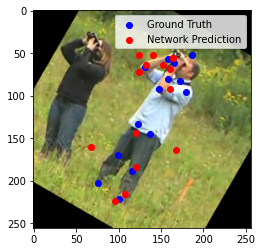

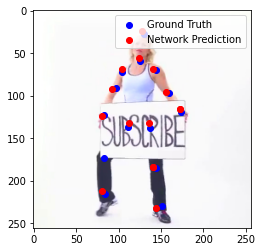

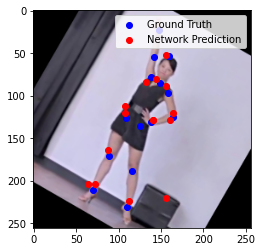

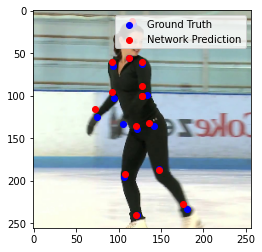

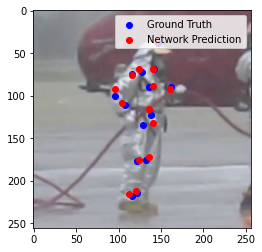

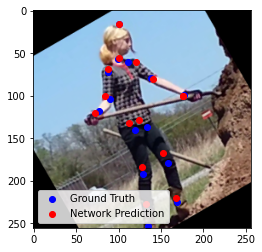

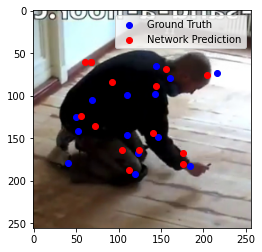

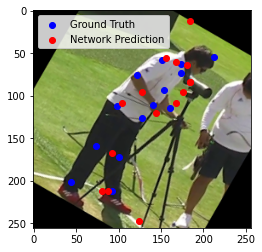

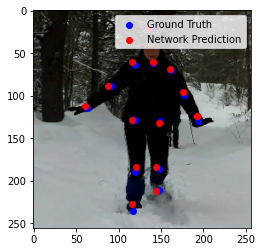

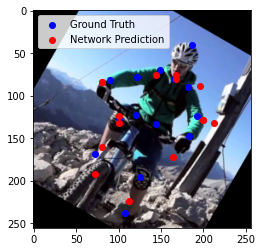

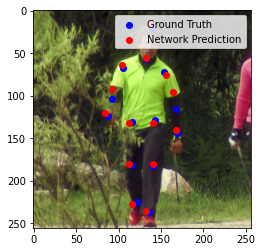

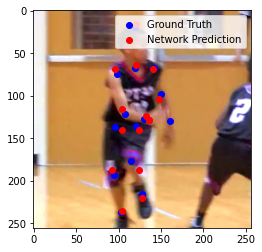

In [12]:
#Input:  model       ---->>>   Trained model on which the inference is to be run
#        image       ---->>>   Batch images  {bz,3,h,w}
#        joint_pos  ----->>>   ground truth joints data {bz,3, 14}
def inference(model, image, joint_pos, index=None):
      model.eval()
      for bz in range(image.shape[0]):
        img = image[bz]
        joint = joint_pos[bz].cpu().numpy()
        plt.figure()
        plt.imshow(np.uint(img.cpu().numpy().transpose(1,2,0)))
        plt.scatter(joint[0,:],joint[1,:],c = 'b', label="Ground Truth")

        output = model(img.unsqueeze(0))
        heatmaps_pred, depths_pred,_ = output[0]

        flat_pred_inds = heatmaps_pred[0, :]
        for i in range(heatmaps_pred[0].shape[0]):
          heatmap = flat_pred_inds[i].cpu().detach().numpy()
          indf = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)
          plt.scatter(4 * indf[1], 4 * indf[0],c = 'r')
        
        plt.scatter(4 * indf[1], 4 * indf[0],c = 'r', label = "Network Prediction")
        plt.legend()  
        #plt.show()
        if index != None:
          plt.savefig("/content/drive/Shareddrives/CIS680_project_data/Outputs/img" + str(bz+index) +".jpg")
        

path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/one_stack_mpii_heatmap_only_trail_0_epoch_145"

stacks = 1
blocks = 1
num_classes = 14 # Should match number of joints per dataset

model = HourglassNet(Bottleneck, num_stacks=stacks, num_blocks=blocks, num_classes=num_classes)
model = model.to(device)

checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['training_loss']
    
model.eval()

for i, data in enumerate(MPIItrain_loader):
  img          = data["images"]
  joint_pos    = data["joint_pos"]
  inference(model, img, joint_pos, i)
  if i==5:
    break

# Metrics

In [ ]:
# Average Joint Distance

def average_joint_distance(model, test_loader):
    distance_per_joint = torch.zeros(14, device=device)
    img_ct = 0

    with torch.no_grad():
        iter = 0
        for data in test_loader:
            print("Iteration: " + str(iter))
            iter += 1
            img          = data["images"]
            joint_pos    = data["joint_pos"]

            output = model(img)
            heatmaps_pred, depths_pred, pre_fc = output[-1]

            batch_size, _, num_joints = joint_pos.shape
            for bz in range(batch_size):
                img_ct += 1                
                # Grab xy coords for each joint in minibatch and scale to heatmap size
                target = joint_pos[bz].T[:, :2].contiguous() / 4.
                
                pred_max = heatmaps_pred[bz].view(num_joints, -1).argmax(1)
                pred_xy = torch.vstack((pred_max % 64, pred_max // 64)).T

                # euclidean distance in coordinate space
                batch_dist = ((target[:, 0] - pred_xy[:, 0]).pow(2) + (target[:, 1] - pred_xy[:, 1]).pow(2)).pow(.5)
                distance_per_joint += batch_dist
                
        distance_per_joint /= img_ct
        return distance_per_joint
            
            
            
epoch = 145
path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/one_stack_mpii_heatmap_only_trail_0_epoch_{epoch}"

stacks = 1
blocks = 1
num_classes = 14 # Should match number of joints per dataset

model = HourglassNet(Bottleneck, num_stacks=stacks, num_blocks=blocks, num_classes=num_classes)
model = model.to(device)

checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

ajd = average_joint_distance(model, MPIItest_loader)
print(ajd)

In [ ]:
# Ordinal Depth Accuracy

def ordinal_depth_accuracy(depth_model, planar_model, test_loader, use_pre_fc=False):
    correct = 0
    total = 0
    for data in test_loader:
            
        img          = data["images"]
        joint_pos    = data["joint_pos"]
        ord_relation = data["ord_relation"] 

        planar_out = planar_model(img) # shape: ({bz, 14, 64 * 64}, {bz, 14, 3}) 

        loss = 0       
        for heatmaps_pred, _, pre_fc in planar_out:
            if use_pre_fc:
                depths_pred = depth_model(pre_fc)
            else: 
                depths_pred = depth_model(heatmaps_pred)

            for i in range(len(img)):
                if len(depths_pred.shape) == 3:
                    z_i = depths_pred[i, :, 2]        #Shape: {14}
                else:
                    z_i = depths_pred[i]
                z_i        = z_i.view(1, -1)
                pred_rel   = z_i - z_i.T
                target_rel = ord_relation[i,:,:]

                true_behind = (target_rel == -1) & (pred_rel <= -.5)
                true_front = (target_rel == 1) & (pred_rel >= .5)
                true_near = (target_rel == 0) & ((pred_rel > -.5) | (pred_rel < .5))
                correct += len((true_behind | true_front | true_near).nonzero())
                total += 14 ** 2

    return correct / total

planar_model = HourglassNet(Bottleneck, num_stacks=1, num_blocks=1, num_classes=14)
planar_model = planar_model.to(device)
planar_load_path = f"/content/drive/Shareddrives/CIS680_project_data/stacked_hourglass/one_stack_mpii_heatmap_only_trail_0_epoch_145"
checkpoint = torch.load(planar_load_path, map_location=device)
planar_model.load_state_dict(checkpoint['model_state_dict'])

depth_model = DepthPredNet()
depth_model = depth_model.to(device)
depth_load_path = f"/content/drive/Shareddrives/CIS680_project_data/depth_net/trail_0_epoch_22"
checkpoint = torch.load(depth_load_path, map_location=device)
depth_model.load_state_dict(checkpoint['model_state_dict'])

oda = ordinal_depth_accuracy(depth_model, planar_model, MPIItest_loader, use_pre_fc=False)
print(f'Ordinal Depth Accuracy {oda}')
